## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### First, imports and some useful functions

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from lesson_functions import *
%matplotlib inline  

In [2]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=48, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)     

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
def extract_features(imgs, get_features_func):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        file_features = get_features_func(image) 
        features.append(file_features)
    # Return list of feature vectors
    return features

In [3]:
def load_and_split_data():
    notcars = []
    notcars.append(glob.glob('../datasets/vehicle_non_vehicle/non-vehicles/Extras/*'))
    notcars.append(glob.glob('../datasets/vehicle_non_vehicle/non-vehicles/GTI/*'))
    
    cars = []
    for d in ('GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted'):
        cars.append(glob.glob('../datasets/vehicle_non_vehicle/vehicles/{}/*'.format(d)))

    # The datasets have multiple images of each car, one after the other. If we simply shuffle we will
    # likely be training and testing on very similar inputs. So, instead take the first 70% of all images
    # for training and use the last 30% for validation.
    train_fraction = 0.8
    notcars_nsamples = [int(train_fraction * len(x)) for x in notcars]
    cars_nsamples = [int(train_fraction * len(x)) for x in cars]
    print('total cars:', len(cars), sum(cars_nsamples), cars_nsamples)
    print('total notcars:', len(notcars), sum(notcars_nsamples), notcars_nsamples)
    
    train_cars = []
    test_cars = []
    for i in range(len(cars)): 
        train_cars.extend(cars[i][:cars_nsamples[i]])
        test_cars.extend(cars[i][cars_nsamples[i]:])
    
    train_notcars = []
    test_notcars = []
    for i in range(len(notcars)):
        train_notcars.extend(notcars[i][:notcars_nsamples[i]])
        test_notcars.extend(notcars[i][notcars_nsamples[i]:])
        
    print("train_cars:", len(train_cars), "test_cars:", len(test_cars))
    print("train_notcars:", len(train_notcars), "test_notcars:", len(test_notcars))
        
    return train_cars, test_cars, train_notcars, test_notcars      


def get_features_and_labels(train_cars, test_cars, train_notcars, test_notcars, get_features_func):

    
    print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

    t=time.time()
 
    train_car_features = extract_features(train_cars, get_features_func)
    test_car_features = extract_features(test_cars, get_features_func)
    train_notcar_features = extract_features(train_notcars, get_features_func)
    test_notcar_features = extract_features(test_notcars, get_features_func)
    
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    
    
    # Create an array stack of feature vectors
    X = np.vstack((train_car_features, train_notcar_features, test_car_features, test_notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    end_train_data_idx = len(train_car_features) + len(train_notcar_features)
    X_train = scaled_X[:end_train_data_idx]
    X_test = scaled_X[end_train_data_idx:]
    
    # Define the labels vector
    y_train = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_notcar_features))))
    y_test = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))
    print("X: ", len(X_train), len(X_test))
    print("y: ", len(y_train), len(y_test))
    
    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)

    return X_train, X_test, y_train, y_test, X_scaler

### Get the datasets    
train_cars, test_cars, train_notcars, test_notcars = load_and_split_data()

data_info = data_look(train_cars + test_cars, train_notcars + test_notcars)

print('Our data set has', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

total cars: 5 7032 [667, 727, 335, 531, 4772]
total notcars: 2 7174 [4054, 3120]
train_cars: 7032 test_cars: 1760
train_notcars: 7174 test_notcars: 1794
Our data set has 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


In [4]:
### Tunable Parameters
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

def make_feature_extraction_function(cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel):
    def get_feature_func(image):
        # apply color conversion if other than 'RGB'
        features = single_img_features(image, color_space=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True) 
        return features
    return get_feature_func

get_features_func = make_feature_extraction_function(colorspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block,hog_channel)



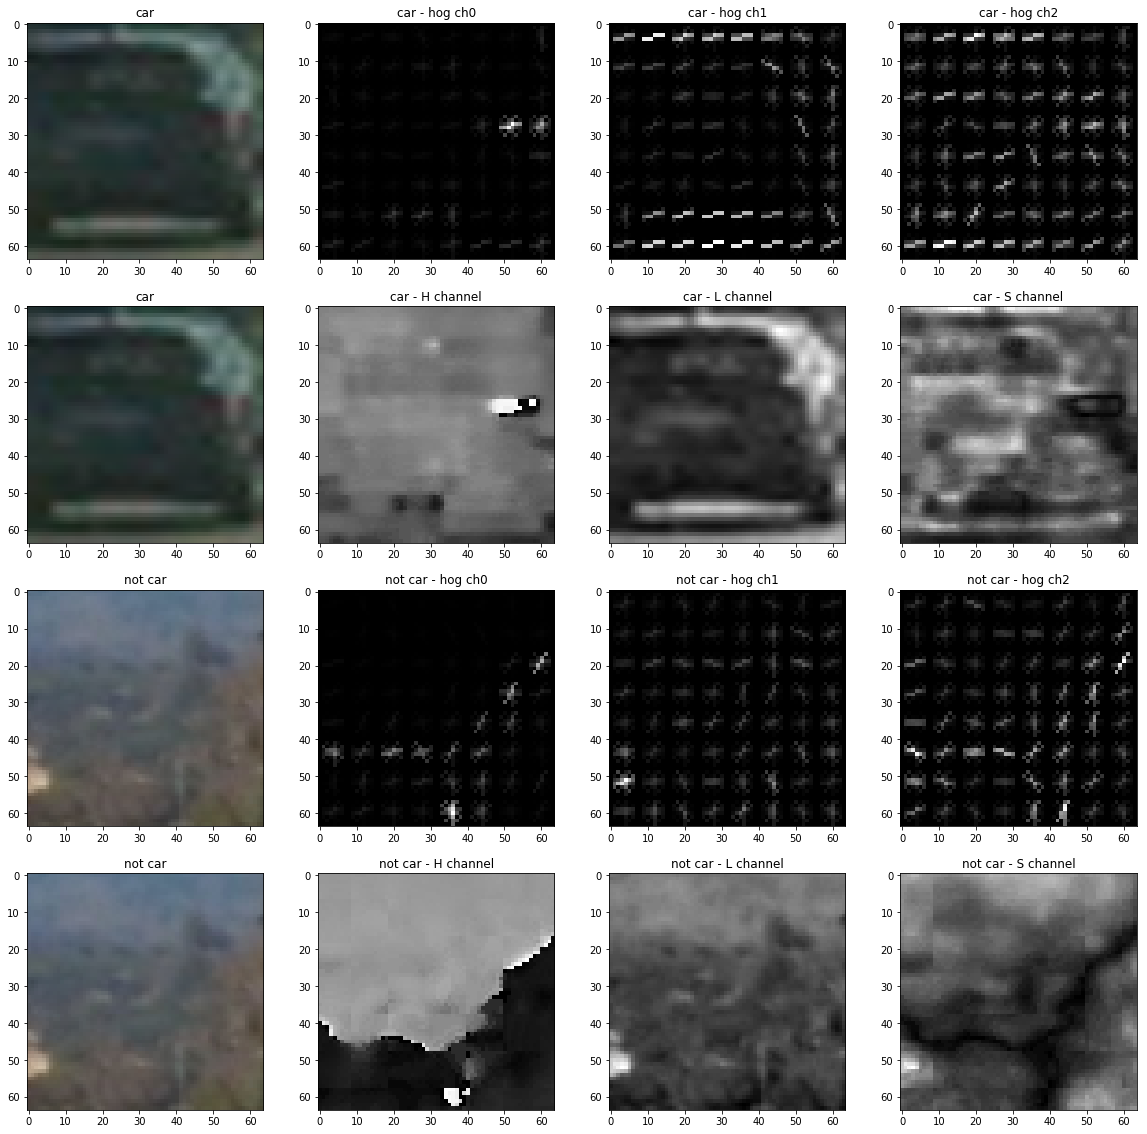

In [5]:
# Explore hog features

img = mpimg.imread(train_cars[20])

test_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
_, hog_img1 = get_hog_features(test_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_img2 = get_hog_features(test_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_img3 = get_hog_features(test_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig, axes = plt.subplots(4, 4, figsize=(20,20))
axes[0][0].imshow(img)
axes[0][0].set_title("car")

axes[0][1].imshow(hog_img1, cmap='gray')
axes[0][1].set_title("car - hog ch0")

axes[0][2].imshow(hog_img2, cmap='gray')
axes[0][2].set_title("car - hog ch1")

axes[0][3].imshow(hog_img3, cmap='gray')
axes[0][3].set_title("car - hog ch2")

axes[1][0].imshow(img)
axes[1][0].set_title("car")

axes[1][1].imshow(test_img[:,:,0], cmap='gray')
axes[1][1].set_title("car - H channel")

axes[1][2].imshow(test_img[:,:,1], cmap='gray')
axes[1][2].set_title("car - L channel")

axes[1][3].imshow(test_img[:,:,2], cmap='gray')
axes[1][3].set_title("car - S channel")


img = mpimg.imread(train_notcars[20])

test_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
_, hog_img1 = get_hog_features(test_img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_img2 = get_hog_features(test_img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_img3 = get_hog_features(test_img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

axes[2][0].imshow(img)
axes[2][0].set_title("not car")

axes[2][1].imshow(hog_img1, cmap='gray')
axes[2][1].set_title("not car - hog ch0")

axes[2][2].imshow(hog_img2, cmap='gray')
axes[2][2].set_title("not car - hog ch1")

axes[2][3].imshow(hog_img3, cmap='gray')
axes[2][3].set_title("not car - hog ch2")

axes[3][0].imshow(img)
axes[3][0].set_title("not car")

axes[3][1].imshow(test_img[:,:,0], cmap='gray')
axes[3][1].set_title("not car - H channel")

axes[3][2].imshow(test_img[:,:,1], cmap='gray')
axes[3][2].set_title("not car - L channel")

axes[3][3].imshow(test_img[:,:,2], cmap='gray')
axes[3][3].set_title("not car - S channel")



In [6]:
X_train, X_test, y_train, y_test, X_scaler = \
    get_features_and_labels(train_cars, test_cars, train_notcars, test_notcars, get_features_func)
    

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
69.17 Seconds to extract HOG features...
X:  14206 3554
y:  14206 3554
Feature vector length: 6156
15.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.]
0.00175 Seconds to predict 10 labels with SVC


## Sliding window detection

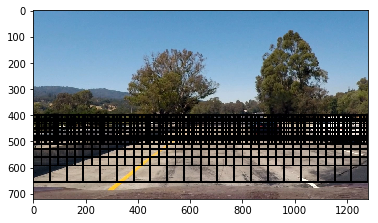

In [7]:
# convert to same scale as png
image = mpimg.imread('test_images/test1.jpg').astype(np.float32) / 255.0

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

window_sizes = [64, 88, 128, 256]
y_start_stops = [(400, 512), (400, 512), (400, 620), (400, 656)]

#window_sizes = [128] #, 128, 256]
#y_start_stops = [(400, 620)] #(400, 656), (400, 656)]

all_windows = []
for window_size, (start, stop) in zip(window_sizes, y_start_stops):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[start, stop], 
                        xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))
    all_windows.extend(windows)

window_img = draw_boxes(image, all_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

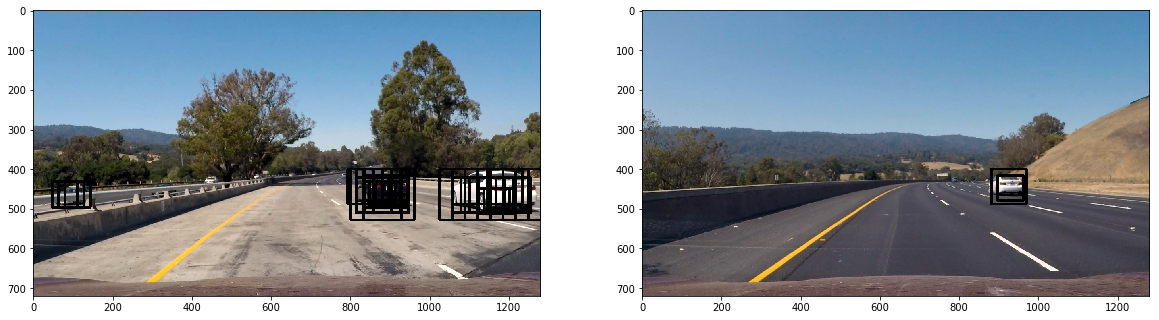

In [8]:
def check_windows(image, windows, get_features_func, X_scaler, svc):
    windows_with_cars = []
    for window in windows:
        x1 = window[0][0]
        y1 = window[0][1]
        x2 = window[1][0]
        y2 = window[1][1]
        
        test_img = cv2.resize(image[y1:y2, x1:x2], (64, 64))
        features = get_features_func(test_img)
        features = X_scaler.transform(features.reshape(1, -1))
        is_car = svc.predict(features)
        if is_car:
            windows_with_cars.append(window)
    return windows_with_cars

image = mpimg.imread('test_images/test1.jpg').astype(np.float32) / 255.0
windows_with_cars = check_windows(image, all_windows, get_features_func, X_scaler, svc)
window_img = draw_boxes(image, windows_with_cars, color=(0, 0, 255), thick=6) 

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,10))
ax0.imshow(window_img)

image = mpimg.imread('./test_images/test3.jpg').astype(np.float32) / 255.0
windows_with_cars = check_windows(image, all_windows, get_features_func, X_scaler, svc)
window_img = draw_boxes(image, windows_with_cars, color=(0, 0, 255), thick=6) 
ax1.imshow(window_img)

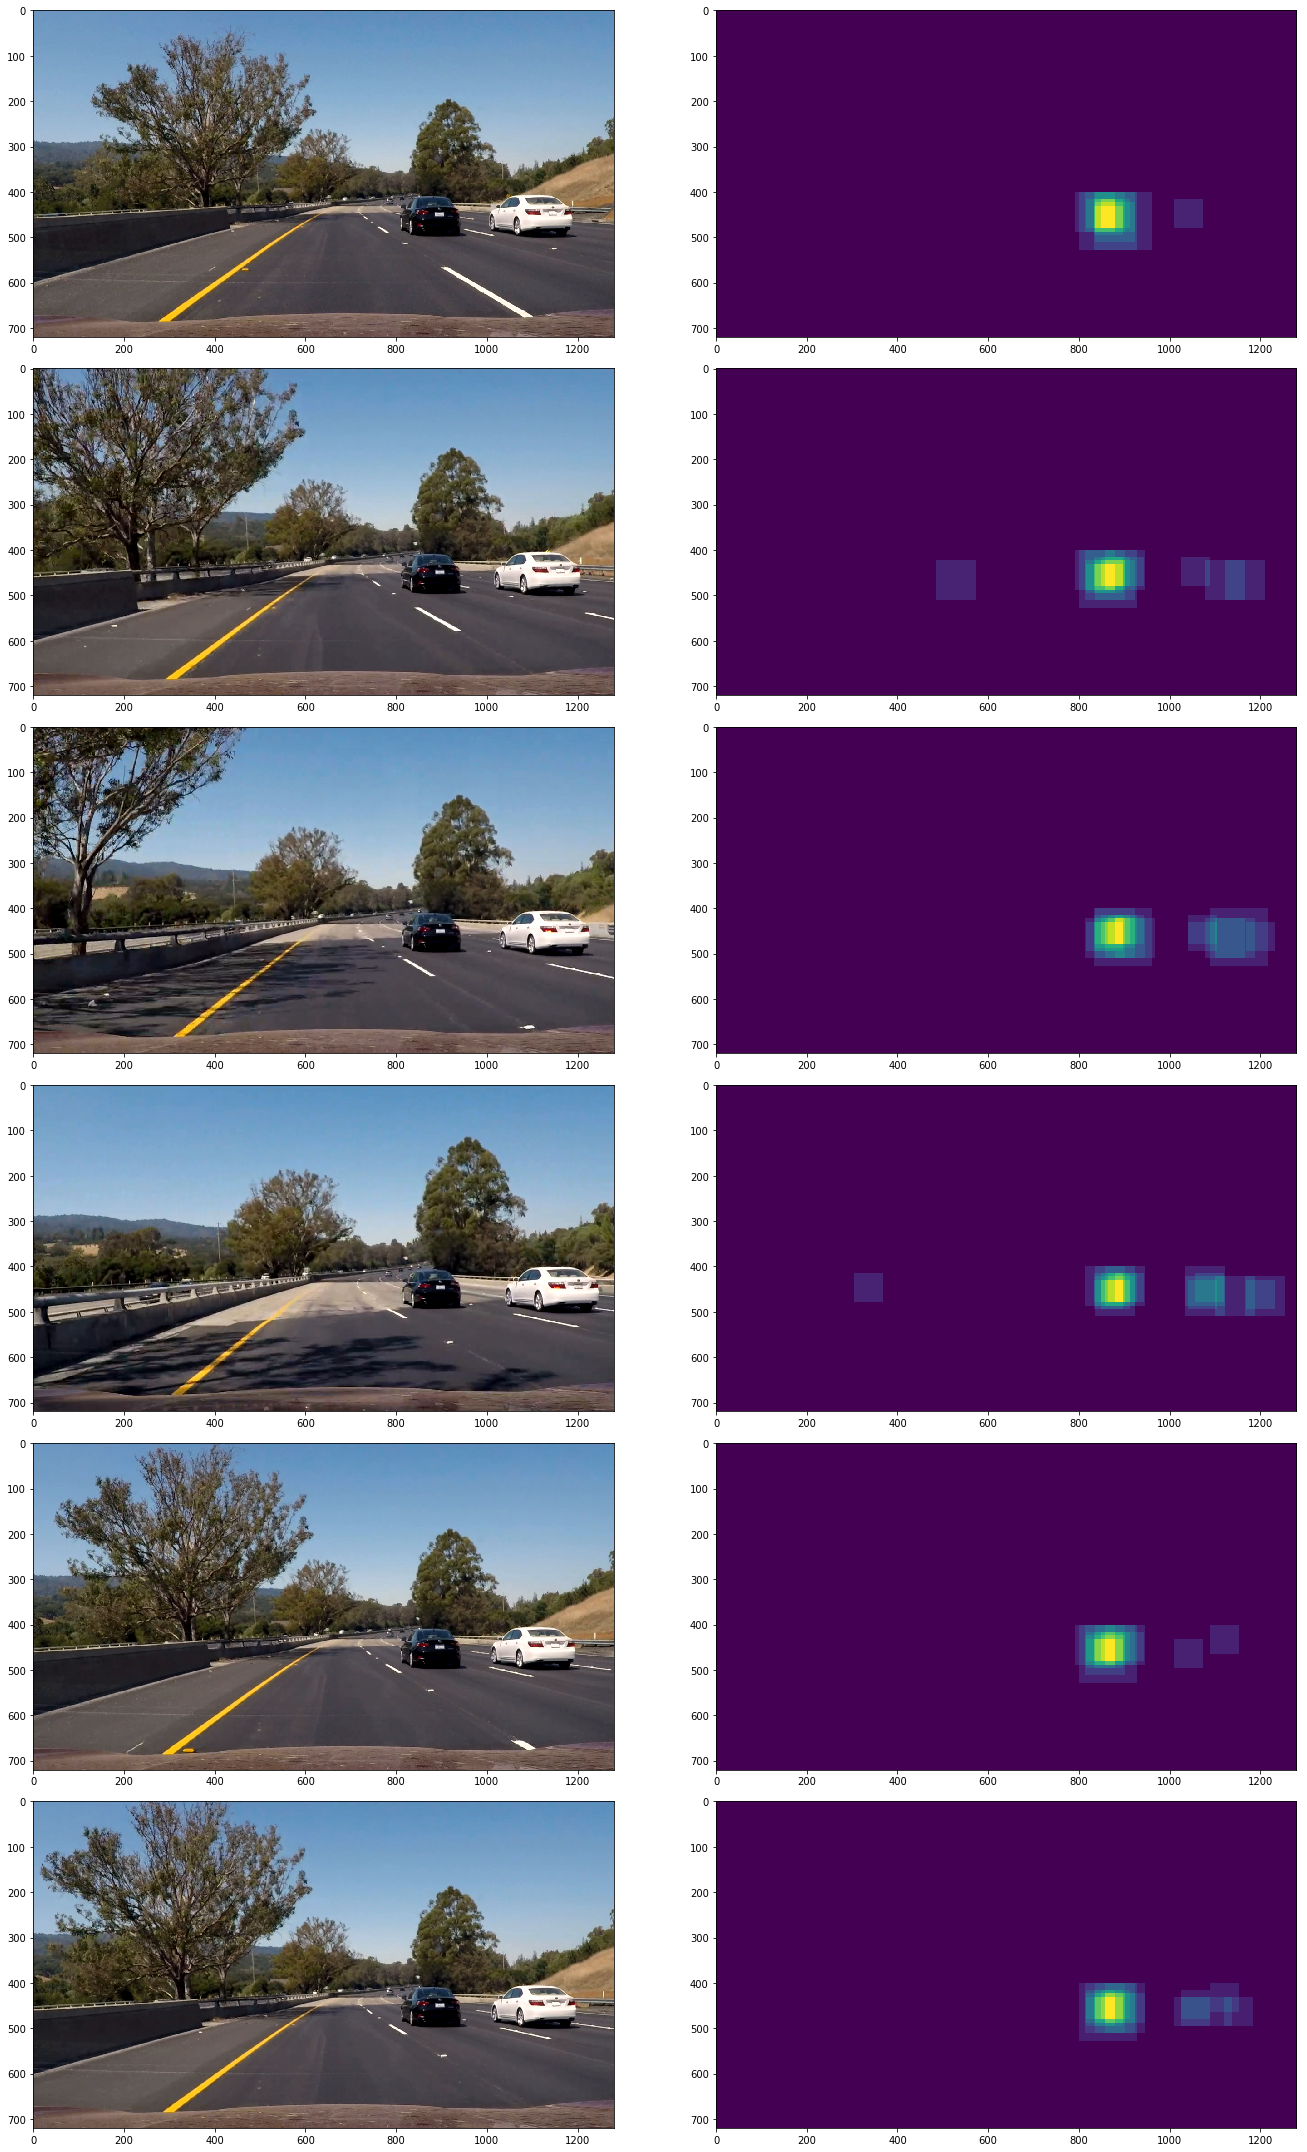

In [14]:
# view the heatmaps and labels of a series of images (10 frames apart each)

from scipy.ndimage.measurements import label

images = []
heatmaps = []
for i in range(6):
    image = mpimg.imread('./output_images/img{}.png'.format(i))
    images.append(image)
    heat = np.zeros_like(image[:,:,0])

    windows_with_cars = check_windows(image, all_windows, get_features_func, X_scaler, svc)
    # Add heat to each box in box list
    heat = add_heat(heat,windows_with_cars)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmaps.append(heatmap)

fig, axes = plt.subplots(6, 2, figsize=(20,30))
i = 0
for (ax0, ax1) in axes:
    ax0.imshow(images[i])
    ax1.imshow(heatmaps[i])
    i+= 1
fig.tight_layout()


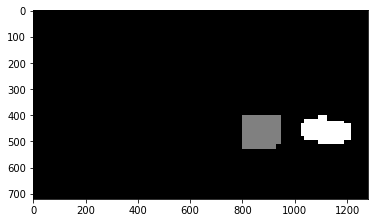

In [17]:
heatmap = heatmaps[0]
for i in range(1,6):
    heatmap += heatmaps[i]
heatmap = apply_threshold(heatmap, 3)    
# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.imshow(labels[0], cmap='gray')

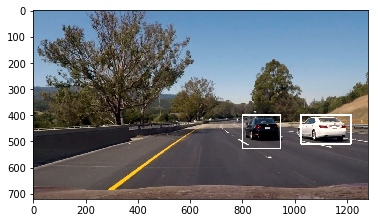

In [18]:
draw_img = draw_labeled_bboxes(np.copy(images[5]), labels)
plt.imshow(draw_img)

In [10]:
import collections

class CarBoxes:
    def __init__(self, num_frames_to_track):
        self._windows = collections.deque(maxlen=num_frames_to_track)
        
    def add_windows(self, windows):
        self._windows.append(windows)            
        
    def get_windows(self):
        windows = []
        for boxes in self._windows:
            windows.extend(boxes)
        return windows

In [11]:
car_boxes = CarBoxes(15)

def process_image(image):
    '''
    Takes an image and returns an image with boxes overlaid on detected cars
    '''
    test_img = image.astype(np.float32) / 255.0
    windows_with_cars = check_windows(test_img, all_windows, get_features_func, X_scaler, svc)

    global car_boxes
    car_boxes.add_windows(windows_with_cars)
    heat = np.zeros_like(image[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat, car_boxes.get_windows())

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 8)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

#img = process_image(image)
#plt.imshow(img)

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

car_boxes = CarBoxes(10)
output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [40:29<00:02,  2.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 40min 18s, sys: 10.2 s, total: 40min 28s
Wall time: 40min 30s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))